<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 3: Choropleth Mapping</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bD/lab_D.html

在本次会议中，我们将以迄今为止所学到的有关加载和操作（空间）数据的所有知识为基础，并将其应用于最常用的空间分析形式之一：choropleths。请记住，这些地图显示以配色方案（也称为 *palette*）编码的变量的空间分布。尽管您可以通过多种方式将变量的值转换为特定颜色，但在此上下文中，我们将仅关注其中的少数几种，特别是：

* 唯一值
* 相等间隔
* 分位数
* Fisher-Jenks

在进入代码之前，让我们了解一下不同的分类方案： https://mgimond.github.io/Spatial/symbolizing-features.html#an-interactive-example

In [3]:
import geopandas
from pysal.lib import examples
import seaborn as sns
import pandas as pd
from pysal.viz import mapclassify
import numpy as np
import matplotlib.pyplot as plt

## Data

为了反映本节所基于的[原始章节](https://geographicdata.science/book/notebooks/05_choropleth.html)，我们将使用相同的数据集：[墨西哥人均GDP数据集](https://geographicdata.science/book/data/mexico/README.html)，我们可以将其作为PySAL示例数据集访问。您可以在此处阅读有关 PySAL 示例数据集的更多信息(https://pysal.org/libpysal/notebooks/examples.html)。

我们可以通过`explain`方法获得数据集的简短解释：

In [4]:
examples.explain("mexico")

mexico

Decennial per capita incomes of Mexican states 1940-2000
--------------------------------------------------------

* mexico.csv: attribute data. (n=32, k=13)
* mexico.gal: spatial weights in GAL format.
* mexicojoin.shp: Polygon shapefile. (n=32)

Data used in Rey, S.J. and M.L. Sastre Gutierrez. (2010) "Interregional inequality dynamics in Mexico." Spatial Economic Analysis, 5: 277-298.



In [5]:
mx = examples.load_example("mexico")

这将下载数据并将其放在您的主目录中。我们可以检查存储它的目录：

In [6]:
mx.get_file_list()

['d:\\work\\miniconda3\\lib\\site-packages\\libpysal\\examples\\mexico\\mexico.csv',
 'd:\\work\\miniconda3\\lib\\site-packages\\libpysal\\examples\\mexico\\mexico.gal',
 'd:\\work\\miniconda3\\lib\\site-packages\\libpysal\\examples\\mexico\\mexicojoin.dbf',
 'd:\\work\\miniconda3\\lib\\site-packages\\libpysal\\examples\\mexico\\mexicojoin.prj',
 'd:\\work\\miniconda3\\lib\\site-packages\\libpysal\\examples\\mexico\\mexicojoin.shp',
 'd:\\work\\miniconda3\\lib\\site-packages\\libpysal\\examples\\mexico\\mexicojoin.shx',
 'd:\\work\\miniconda3\\lib\\site-packages\\libpysal\\examples\\mexico\\README.md']

在本节中，我们将读取 ESRI 形状文件，这可以通过将`geopandas.read_file`指向`.shp`文件来完成。实用程序函数`get_path`使我们更容易一些：

In [7]:
db = geopandas.read_file(examples.get_path("mexicojoin.shp"))

In [8]:
type(db)

geopandas.geodataframe.GeoDataFrame

而且，从现在开始，`db`是一个表格，正如我们在本课程中到目前为止所习惯的那样：

In [9]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POLY_ID     32 non-null     int64   
 1   AREA        32 non-null     float64 
 2   CODE        32 non-null     object  
 3   NAME        32 non-null     object  
 4   PERIMETER   32 non-null     float64 
 5   ACRES       32 non-null     float64 
 6   HECTARES    32 non-null     float64 
 7   PCGDP1940   32 non-null     float64 
 8   PCGDP1950   32 non-null     float64 
 9   PCGDP1960   32 non-null     float64 
 10  PCGDP1970   32 non-null     float64 
 11  PCGDP1980   32 non-null     float64 
 12  PCGDP1990   32 non-null     float64 
 13  PCGDP2000   32 non-null     float64 
 14  HANSON03    32 non-null     float64 
 15  HANSON98    32 non-null     float64 
 16  ESQUIVEL99  32 non-null     float64 
 17  INEGI       32 non-null     float64 
 18  INEGI2      32 non-null     float64 
 19  MA

In [10]:
db.geometry

0     MULTIPOLYGON (((-113.13972 29.01778, -113.2405...
1     MULTIPOLYGON (((-111.20612 25.80278, -111.2302...
2     MULTIPOLYGON (((-106.62108 21.56531, -106.6475...
3     POLYGON ((-101.52490 21.85664, -101.58830 21.7...
4     POLYGON ((-101.84620 22.01176, -101.96530 21.8...
5     POLYGON ((-100.28030 20.20451, -100.34860 20.0...
6     POLYGON ((-100.12280 19.93804, -100.18250 20.0...
7     POLYGON ((-98.65941 19.58540, -98.65556 19.595...
8     POLYGON ((-103.47960 18.96722, -103.34830 18.9...
9     POLYGON ((-98.62798 19.47576, -98.66612 19.405...
10    POLYGON ((-99.28487 19.14244, -99.34056 19.357...
11    POLYGON ((-103.74548 18.68807, -104.00446 18.8...
12    POLYGON ((-98.66223 18.99676, -98.65640 18.905...
13    POLYGON ((-90.37337 20.84530, -90.33890 20.941...
14    MULTIPOLYGON (((-91.83446 18.63805, -91.84195 ...
15    POLYGON ((-96.75063 18.43083, -96.72639 18.385...
16    MULTIPOLYGON (((-88.29950 18.48293, -88.48395 ...
17    POLYGON ((-98.14307 19.67278, -98.00111 19

但是，数据不包括CRS：

In [11]:
db.crs

为了能够添加基础层，我们需要指定一个。查看详细信息和原始参考，我们发现数据以经度和纬度表示，因此我们可以使用的CRS是`EPSG：4326`。让我们将其添加到`db`中：

In [12]:
db.crs = "EPSG:4326"
db.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Choropleths

### 唯一值

分类变量的分区统计只是为序列中的每个潜在值分配不同的颜色。在这种情况下，主要要求是配色方案反映不同的值不排序或遵循特定比例的事实。

在 Python 中，只需一行代码即可创建分类 choropleth。为了证明这一点，我们可以根据墨西哥统计局（在我们的表中编码为`INEGI`变量）绘制墨西哥各州和各州所属的地区：

<AxesSubplot:>

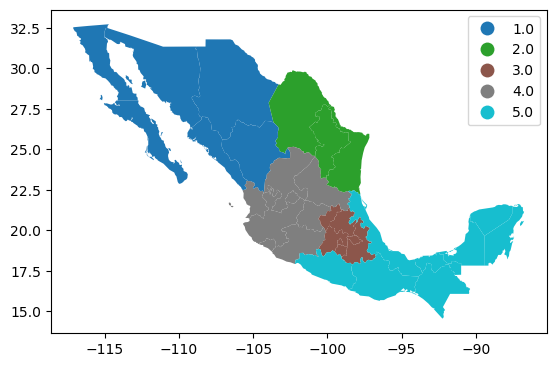

In [13]:
db.plot(
    column="INEGI", 
    categorical=True, 
    legend=True
)

让我们在几个关键方面停下来：

* 请注意，我们如何使用与基本地图相同的方法，命令`plot`，但是我们现在需要添加参数`column`来指定要表示的特定列。
* 由于变量是分类的，我们需要通过将参数`分类`设置为`True`来明确这一点。
* 作为可选参数，我们可以将`legend`设置为`True`，结果图形将包含一个图例，其中包含地图中所有值的名称。
* 除非我们指定不同的颜色图，否则所选的颜色图尊重数据的分类性质，不暗示梯度或比例，而是定性结构。

### 相等间隔

如果我们想显示连续现象的地理分布，而不是分类变量，我们需要选择一种方法将每个值编码为颜色。一种可能的解决方案是应用通常称为“相等间隔”的方法。这种方法的直觉是将分布的*范围*（最小值和最大值之间的差异）分成同样大的段，并根据反映值排序事实的调色板为每个段分配不同的颜色。

在 Python 中创建分区统计相对简单。例如，要为 2000 年的人均 GDP 创建一个相等的区间 （'PCGDP2000'），我们可以运行类似的命令，如下所示：

<AxesSubplot:>

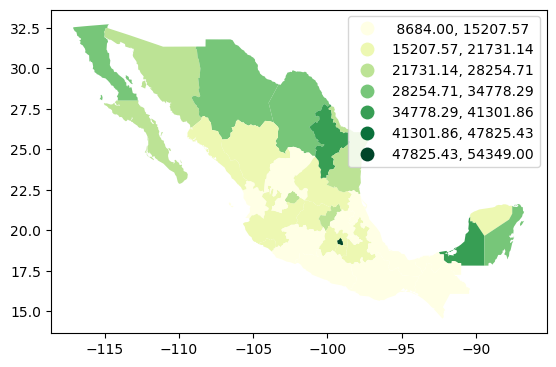

In [14]:
db.plot(
    column="PCGDP2000", 
    scheme="equal_interval", 
    k=7,
    cmap="YlGn",
    legend=True
)

注意主要区别：

* 我们没有将`分类`指定为`True`，而是将其替换为参数`scheme`，我们将将其用于所有需要连续分类方案的choropleth。在本例中，我们将其设置为`equal_interval`。
*如上所述，我们将颜色数量设置为7。请注意，我们不需要传递上面计算的箱，绘图方法本身就是为我们做的。
* 作为可选参数，我们可以将颜色图更改为黄色到绿色渐变，这是 [ColorBrewer](http://colorbrewer2.org/)推荐的顺序调色板之一。

现在，让我们更深入地了解分类，以及我们如何准确地将值编码为颜色。每个段，也称为箱或桶，也可以使用`PySAL`系列中的库`mapclassify`进行计算：

In [15]:
classi = mapclassify.EqualInterval(db["PCGDP2000"], k=7)
classi

EqualInterval               

      Interval         Count
----------------------------
[ 8684.00, 15207.57] |    10
(15207.57, 21731.14] |    10
(21731.14, 28254.71] |     5
(28254.71, 34778.29] |     4
(34778.29, 41301.86] |     2
(41301.86, 47825.43] |     0
(47825.43, 54349.00] |     1

除了我们要分类的实际变量之外，传递给 'Equal_Interval' 的唯一附加参数是我们想要创建的段数 'k'，在这种情况下我们将其任意设置为 7。这将是将在地图上绘制的颜色数量，因此，尽管拥有几种颜色可以提供更多细节，但在某些时候，考虑到大脑分辨任何差异的能力，额外颜色的边际价值相当有限。

对变量进行分类后，我们可以检查实际的断点，其中值不再在一个类中并成为下一个类的一部分：

In [16]:
classi.bins

array([15207.57142857, 21731.14285714, 28254.71428571, 34778.28571429,
       41301.85714286, 47825.42857143, 54349.        ])

上面的断点数组意味着变量中低于 15，207.57 的任何值在映射时都将获得渐变中的第一个颜色，下一个值介于 15，207.57 和 21，731.14 之间的值，依此类推。

相等间隔地图的关键特征是，根据值的大小分配条柱，而不管每个条柱中有多少个观测值因此而落入。在高度偏斜的分布中，这可能会导致具有大量观测值的条柱，而其他条柱只有少数异常值。这可以在上面打印的汇总表中看到，其中十个州在第一组中，但其中只有一个属于具有最高值的州。这也可以用核密度图直观地表示，其中也包括断点：

C:\Users\24365\AppData\Local\Temp\ipykernel_9392\1696127768.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(db["PCGDP2000"], shade=True)


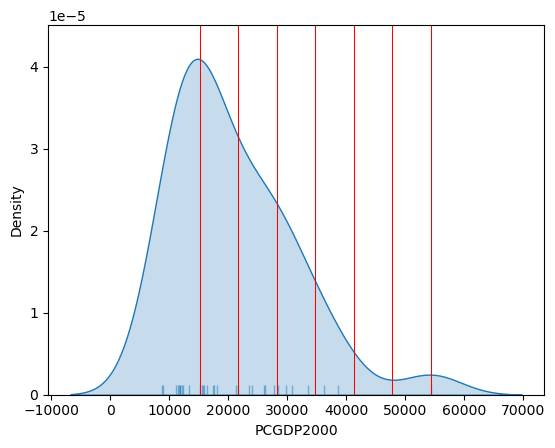

In [17]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(db["PCGDP2000"], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(db["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

从技术上讲，该图是通过为每个断点叠加带有垂直条的 KDE 图来创建的。这使得突出的问题更加明确，即第一个箱包含大量观测值，而具有最高值的箱仅包含其中的少数观测值。

### 分位数

获得更平衡分类方案的一种解决方案是使用分位数。根据定义，这将为每个箱分配相同数量的值：整个序列按顺序布局，断点的分配方式在每个条柱之间留下完全相同的观测值数量。这种`基于观测`的方法与相等间隔的`基于值`的方法形成对比，尽管它可以掩盖极值的大小，但在分布偏斜的情况下，它可以提供更多的信息。

创建上述所需分区统计镜像所需的代码：

<AxesSubplot:>

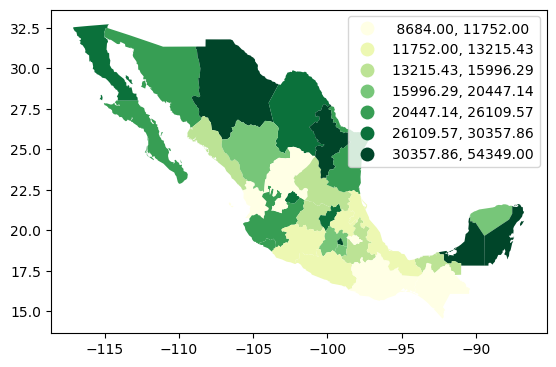

In [18]:
db.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=True
)

请注意，在这种情况下，根据定义，每种颜色的多边形数量如何更加平衡（实际上几乎相等，除了舍入差异）。这掩盖了异常值，这些值被同一组中明显较小的值模糊，但允许在分布的“人口最多”部分获得更多细节，其中我们现在可以识别更多的变异性，而不仅仅是白色多边形。

为了进一步了解分位数分类，让我们用`mapclassify`来计算它：

In [19]:
classi = mapclassify.Quantiles(db["PCGDP2000"], k=4)
classi

Quantiles                   

      Interval         Count
----------------------------
[ 8684.00, 12308.75] |     8
(12308.75, 17444.00] |     8
(17444.00, 26557.25] |     8
(26557.25, 54349.00] |     8

同样，还可以检查bins：

In [20]:
classi.bins

array([12308.75, 17444.  , 26557.25, 54349.  ])

分布的可视化也可以以类似的方式生成：

C:\Users\24365\AppData\Local\Temp\ipykernel_9392\1696127768.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(db["PCGDP2000"], shade=True)


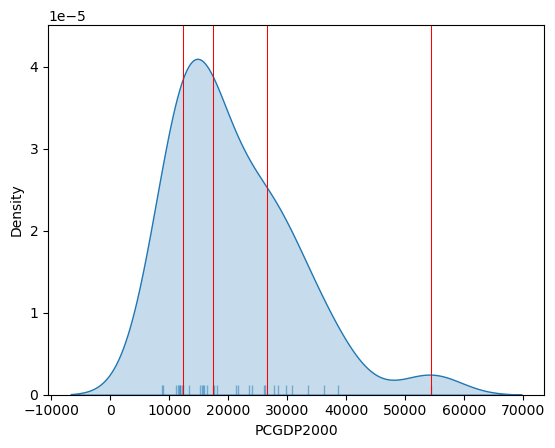

In [21]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(db["PCGDP2000"], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(db["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

### Fisher-Jenks

相等区间和分位数只是将值编码为颜色的许多分类方案中的两个示例。虽然不是所有的分类都集成到`geopandas`中，但`PySAL`包括其他几种分类方案（有关详细列表，请查看此[链接](https://pysal.org/mapclassify/notebooks/01_maximum_breaks.html)）。作为更复杂的示例，让我们创建一个 Fisher-Jenks choropleth：

<AxesSubplot:>

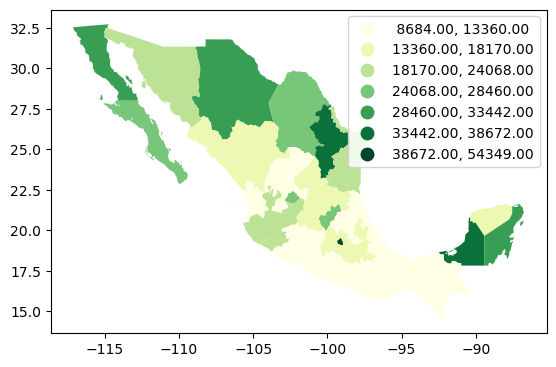

In [22]:
db.plot(
    column="PCGDP2000", 
    scheme="fisher_jenks", 
    k=7,
    cmap="YlGn",
    legend=True
)

使用与以前类似的方法可以获得相同的分类：

In [23]:
classi = mapclassify.FisherJenks(db["PCGDP2000"], k=7)
classi

FisherJenks                 

      Interval         Count
----------------------------
[ 8684.00, 13360.00] |    10
(13360.00, 18170.00] |     8
(18170.00, 24068.00] |     4
(24068.00, 28460.00] |     4
(28460.00, 33442.00] |     3
(33442.00, 38672.00] |     2
(38672.00, 54349.00] |     1

这种方法旨在最小化每个箱内的方差，同时最大化不同类之间的方差。

In [24]:
classi.bins

array([13360., 18170., 24068., 28460., 33442., 38672., 54349.])

从图形上看，我们可以看到断点不是等间距的，而是在调整以获得最佳的观测分组：

C:\Users\24365\AppData\Local\Temp\ipykernel_9392\1696127768.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(db["PCGDP2000"], shade=True)


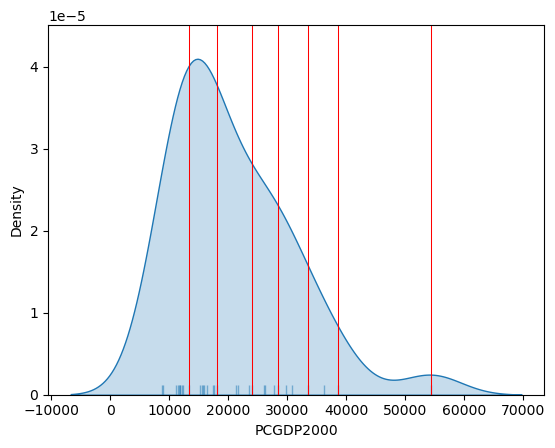

In [25]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(db["PCGDP2000"], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(db["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

例如，具有最高值的 bin 比具有最低值的 bin 覆盖的范围要宽得多，因为该值范围内的状态较少。

## 放大地图

### 放大到全地图

整个地区或城市地区的一般地图有时会掩盖局部模式，因为它们发生在更小的比例上，无法在全球视图中感知。解决此问题的一种方法是在单独的图中提供地图较小部分的焦点。尽管在 Python 中有很多方法可以做到这一点，但最直接的方法是重置轴的限制，使它们在感兴趣的区域中居中。

作为一个例子，让我们考虑上面生成的分位数图：

<AxesSubplot:>

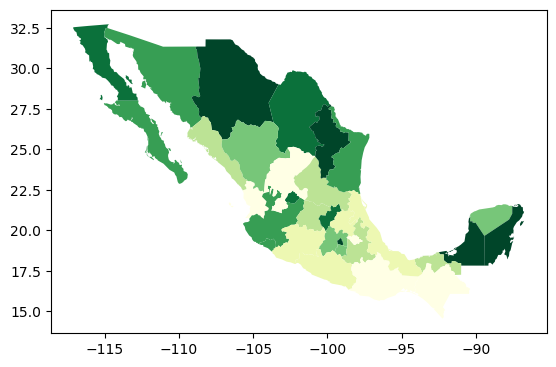

In [26]:
db.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False
)

如果我们想关注首都墨西哥DF，第一步是意识到地图的此类区域（地图东南中心的小深绿色多边形）大致在-102W / -97W和18N / 21N的坐标范围内。要显示该区域的缩放地图，我们可以执行以下操作：

(-102.0, -97.0)

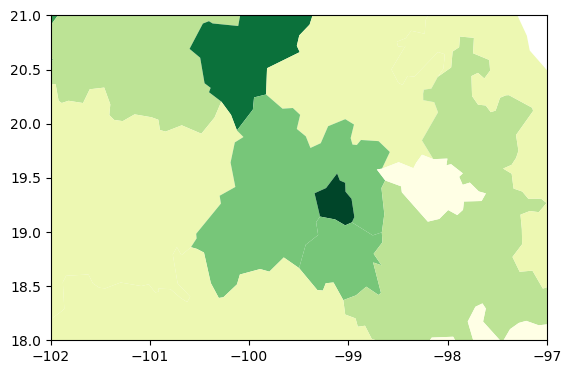

In [27]:
# Setup the figure
f, ax = plt.subplots(1)
# Draw the choropleth
db.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False,
    ax=ax
)
# Redimensionate X and Y axes to desired bounds
ax.set_ylim(18, 21)
ax.set_xlim(-102, -97)

### 部分地图

上面的方法很简单，但不一定是最有效的方法：并不是说，要生成一个可能非常小区域的地图，我们有效地绘制了整个（可能非常大）地图，并丢弃了除我们想要的部分之外的所有内容。乍一看这并不容易注意到，但是 Python 在上面的代码单元格中所做的是绘制整个 'db' 对象，然后才将图形集中在 'set_xlim'/'set_ylim' 中指定的 X 和 Y 范围上。

有时，这是必需的。例如，如果我们想保留与国家地图相同的颜色，但专注于墨西哥DF周围的地区，这种方法是最简单的方法。

但是，有时，我们只需要绘制给定范围内的_geographical features_，并且我们要么不需要保留国家着色（例如，我们使用单一颜色），要么我们希望对区域中的特征执行分类_only_。

对于这些情况，首先选择要绘制的数据，然后通过`plot`显示它们在计算上更有效。为此，我们可以依靠`cx`运算符（基于坐标的索引）： https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.cx.html

<AxesSubplot:>

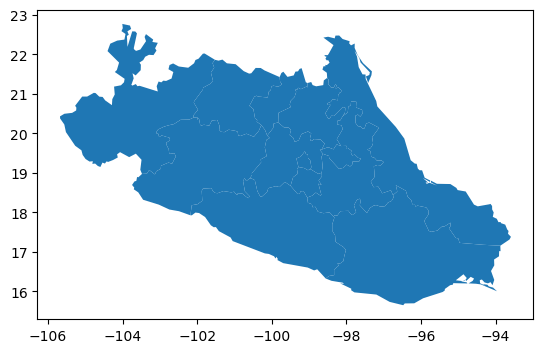

In [28]:
subset = db.cx[-102:-97, 18:21]
subset.plot()

我们查询空间坐标的范围类似于使用`loc`查询索引的方式。但请注意，结果包括完整的地理要素，因此将完全包含范围内至少具有某些区域的面。这会导致范围大于最初指定的范围。

这种方法是一种`空间切片`，其中切片不是按表的索引进行子集化，而是基于表中表示的数据的空间坐标。

由于结果本身就是`GeoDataFrame`，我们可以创建一个仅基于子集中数据的分区统计：

<AxesSubplot:>

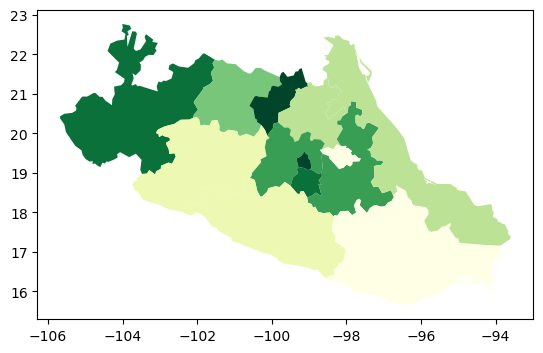

In [29]:
subset.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False
)